## Script to parse behavioral data from pickle files

The purpose of this notebook is to parse the behavioral data in the appropriate pickle files into a format that is easily usable for analysis and plotting.

The pickle files for each animal contain dictionaries where the keys are session names and the values are lists of trials where every trial is a dictionary of this form:

```            trial = {
                'trial_num': 347,
                'stim_presentation_time': 1134567, # in microseconds
                'behavior_outcome_time': 1734567, # in microseconds
                'reaction_time': 600000, # in microseconds
                'behavior_outcome': 'success', # can be 'success', 'failure' or 'ignore'
                'BlobIdentityIdx': 1, # can be 1 or 2
                'response_location': 'left', # can be 'left' or 'right' corresponding to lickport
                'answer_location': 'left' # can be 'left' or 'right' (lickport location that is correct on trial)
            }
```

Continue below for how these data will be transformed. Make sure to run these cells in order.

### Dependencies

In [1]:
from __future__ import division
import csv
import hddm
import os
import math
import random
import scipy
from pylab import figure
import seaborn as sns
import scipy.stats as stats
import numpy as np
import pymworks
import pickle
import pandas as pd
from collections import Counter
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/pymworks/protocol/__init__.py:15: UserWarning: networkx is required for pymworks.protocols.states
  warnings.warn('networkx is required for pymworks.protocols.states')


### Functions  and parameters needed to parse the pickle files

##### Parameters for running parsing

In [2]:
bootstrap_iterations = 100 # choose number of bootstrap iterations for calculating performance error
wiggle_session_indices = False # for binning data over normalized session time. if True adds random noise to session_indices so they don't completely overlap if same number of sessions, etc

##### Location of files

In [10]:
# filepaths of data to analyze

# transparent/dim
filepath_transparency = './_psytrack/_data/transparency_psytrack/pickle_files_by_session/'

# fullcross baseline before transparent/dim
filepath_reg_before_transparency = './_psytrack/_data/fullcross_before_transparency_psytrack/pickle_files_by_session/'

##### Defining functions

**Logic:**

Function ```open_pickle_files_and_analyze()``` takes in the ```filepath``` as input, finds the pickle files, and then runs the function ```get_data```

Function ```get_data()``` takes in ```animal_name``` and ```trials_grouped_by_session``` as input, and then outputs a dictionary with the parsed data of the following form:

``` data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'iti_by_trial': iti_by_trial,
    'response_location_by_trial': response_location_by_trial,
    'answer_location_by_trial': answer_location_by_trial,
    'stim_id_by_trial': stim_id_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'response_location_by_session': response_location_by_session,
    'answer_location_by_session': answer_location_by_session,
    'stim_id_by_session': stim_id_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'bootstrap_error_by_session': bootstrap_error_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_error_by_session': rt_success_error_by_session,
    'rt_failure_error_by_session': rt_failure_error_by_session,
    'rt_error_by_session': rt_error_by_session,
    'norm_session_indices': norm_session_indices
    } 
```

where:

- ***animal_name*** : animal name  
- **rt_by_trial** : list of individual trial reaction times across all sessions in pickle file
- **outcome_by_trial** : list of individual trial outcomes ('success', 'failure') across all sessions in pickle file
- **iti_by_trial** : list of individual trial intertrial intervals across all sessions in pickle file
- **response_location_by_trial**: list of 'left' or 'right' for lickport response 
- **answer_location_by_trial**: list of 'left' or 'right' for correct lickport on that trial 
- **stim_id_by_trial**: list of 0 or 1 for BlobIdentityIdx (which stimulus was shown) for every trial

- **beh_outcome_by_session** : dict where key = session, val = of individual trial outcomes ('success', 'failure')
- **rt_by_session** : dict where key = session, val = individual trial reaction times
- **rt_success_by_session** : dict where key = session, val = individual success trial reaction times
- **rt_failure_by_session** : dict where key = session, val = individual failure trial reaction times
- **iti_by_session** : dict where key = session, val = individual trial intertrial intervals
- **response_location_by_session**: dict where key = session, val = list of 'left' or 'right' for lickport response 
- **answer_location_by_session**: dict where key = session, val = list of 'left' or 'right' for correct lickport on that trial 
- **stim_id_by_session**: dict where key = session, val = list of 0 or 1 for BlobIdentityIdx (which stimulus was shown) for every trial

- **pct_correct_by_session** : dict where key = session, val = accuracy for that session
- **bootstrap_error_by_session** : dict where key = session, val = bootstrapped accuracy error for that session
    
- **avg_rt_success_by_session** : dict where key = session, val = avg RT for success trials in that session
- **avg_rt_failure_by_session** : dict where key = session, val = avg RT for failure trials in that session
- **rt_success_error_by_session** : dict where key = session, val = bootstrapped RT error for success trials in that session
- **rt_failure_error_by_session** : dict where key = session, val = bootstrapped RT error for success trials in that session

- **norm_session_indices** : list of indices for sessions normalized from 0 to 1 (if animal takes 10 sessions to learn, then list contains [0.1, 0.2, 0.3,...,1.0]

the user can then use this data as she/he/they pleases. Some examples in the cells below.

In [4]:
def open_pickle_files_and_analyze(filepath):
    # get list of pickle file filenames in filepath
    dirs_list = [each for each in os.walk(filepath)]
    dirs_list = dirs_list[0][2] # capture only the pickle file filenames
    dirs_list = [i for i in dirs_list if i.startswith('.') == False] # remove hidden files

    # initiate dictionaries that will hold data
    results_by_session = {} # dictionary where keys will be animals, and values will be data
    sessions_by_animal = {} # dictionary where keys will be animals, and values will be session names

    # load the pickle files in the dirs_list one by one
    for filename in dirs_list:
        with open(filepath + filename, 'rb') as handle:
            data = pickle.load(handle)
        
        animal = list(data.keys())[0]# get animal name

        # notify the user of the sessions that are read
        print(' ')
        print('Read data from', animal, 'for...')
        print('sessions:')
        for session in sorted(data[animal].keys()):
            print(session)

        # lump sessions from all phases into one dictionary
        trials_grouped_by_session = data[animal]
        
        # then analyze
        result_by_session = get_data(animal, trials_grouped_by_session) # analyze one animal at a time
        # store data in dictionaries
        results_by_session[animal] = result_by_session # add to results_by_session dictionary
        sessions_by_animal[animal] = result_by_session['avg_rt_success_by_session'].keys() # add sessions to sessions_by_animal dictionary

    return results_by_session

def get_data(animal_name, trials_grouped_by_session):
    
    # ~~~~~~~~~ Capture trial data ~~~~~~~~~
    
    data_by_trial = trial_data(trials_grouped_by_session)
    rt_by_trial = data_by_trial['rt_by_trial']
    outcome_by_trial = data_by_trial['outcome_by_trial']
    iti_by_trial = data_by_trial['iti_by_trial']
    response_location_by_trial = data_by_trial['response_location_by_trial']
    answer_location_by_trial = data_by_trial['answer_location_by_trial']
    stim_id_by_trial = data_by_trial['stim_id_by_trial']
    
    # ~~~~~~~~~ Capture session data ~~~~~~~~~
    
    data_by_session = session_data(trials_grouped_by_session)
    beh_outcome_by_session = data_by_session['beh_outcome_by_session']
    rt_by_session = data_by_session['rt_by_session']
    rt_success_by_session = data_by_session['rt_success_by_session']
    rt_failure_by_session = data_by_session['rt_failure_by_session']
    iti_by_session = data_by_session['iti_by_session']
    response_location_by_session = data_by_session['response_location_by_session']
    answer_location_by_session = data_by_session['answer_location_by_session']
    stim_id_by_session = data_by_session['stim_id_by_session']
    
    # ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

    avg_rt_success_by_session = average_data_rt(rt_success_by_session)
    avg_rt_failure_by_session = average_data_rt(rt_failure_by_session)
    avg_rt_by_session = average_data_rt(rt_by_session)

    rt_success_error_by_session = bootstrap_error_rt(rt_success_by_session, bootstrap_iterations)
    rt_failure_error_by_session = bootstrap_error_rt(rt_failure_by_session, bootstrap_iterations)
    rt_error_by_session = bootstrap_error_rt(rt_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~ Performance analysis ~~~~~~~~~~
    
    pct_correct_by_session = pct_correct(beh_outcome_by_session)
    
    bootstrap_error_by_session = bootstrap_error_perf(beh_outcome_by_session, bootstrap_iterations)
    
    # ~~~~~~~~~~~~ Session indices ~~~~~~~~~~~~

    norm_session_indices = [(x+1)/len(pct_correct_by_session) for x in range(len(pct_correct_by_session))]
    norm_session_indices = [(x+1)/len(avg_rt_success_by_session) for x in range(len(avg_rt_success_by_session))]

    data = {
    'animal_name': animal_name,
    'rt_by_trial': rt_by_trial,
    'outcome_by_trial': outcome_by_trial,
    'iti_by_trial': iti_by_trial,
    'response_location_by_trial': response_location_by_trial,
    'answer_location_by_trial': answer_location_by_trial,
    'stim_id_by_trial': stim_id_by_trial,
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'response_location_by_session': response_location_by_session,
    'answer_location_by_session': answer_location_by_session,
    'stim_id_by_session': stim_id_by_session,
    'pct_correct_by_session': pct_correct_by_session,
    'bootstrap_error_by_session': bootstrap_error_by_session,
    'avg_rt_success_by_session': avg_rt_success_by_session,
    'avg_rt_failure_by_session': avg_rt_failure_by_session,
    'avg_rt_by_session': avg_rt_by_session,
    'rt_success_error_by_session': rt_success_error_by_session,
    'rt_failure_error_by_session': rt_failure_error_by_session,
    'rt_error_by_session': rt_error_by_session,
    'norm_session_indices': norm_session_indices
    }

    return data

# ~~~~~~~~~ Capture trial data ~~~~~~~~~

# get trial data in big lists across all sessions
def trial_data(trials_grouped_by_session):
    # initialize lists for trial data across all sessions
    rt = []
    outcome = []
    iti = []
    resp_loc = []
    answ_loc = []
    stim_id = []

    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.keys()):
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            
            # only take into account the success or failure trials
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']:
               
                # append reaction time 
                rt.append(trials[trial_index]['reaction_time'])
                # append behavior outcome
                outcome.append(trials[trial_index]['behavior_outcome'])
                # append response location and correct answer location
                resp_loc.append(trials[trial_index]['response_location'])
                answ_loc.append(trials[trial_index]['answer_location'])
                # append stimulus identity
                stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                
                
                # intertrial interval analysis
                if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                    iti.append(iti_for_first_trial)
                elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                    next_stim_time = trials[trial_index]['stim_presentation_time']
                    response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                    inter_trial_interval = (next_stim_time - response_time)*0.001
                    iti.append(inter_trial_interval)
                    
            # ignore the 'ignore' trials for now
            elif trials[trial_index]['behavior_outcome'] == 'ignore':
                pass 
          
    data_by_trial = {
    'rt_by_trial': rt,
    'outcome_by_trial': outcome,
    'iti_by_trial': iti,
    'response_location_by_trial': resp_loc,
    'answer_location_by_trial': answ_loc,
    'stim_id_by_trial': stim_id
    }
    return data_by_trial

# ~~~~~~~~~ Capture session data ~~~~~~~~~

def session_data(trials_grouped_by_session):
    # initialize dictionaries for trial data by sessions
    beh_outcome_by_session = {}
    rt_by_session = {}
    rt_success_by_session = {}
    rt_failure_by_session = {}
    iti_by_session = {}
    response_location_by_session = {}
    answer_location_by_session = {}
    stim_id_by_session = {}
    
    iti_for_first_trial = 0 # default value for iti when first trial of session
    for session in sorted(trials_grouped_by_session.keys()):
        session_rt_success = []
        session_rt_failure = []
        session_rt = []
        session_behavior_outcome = []
        session_iti = []
        session_resp_loc = []
        session_answ_loc = []
        session_stim_id = []
        trials = trials_grouped_by_session[session]
        for trial_index in range(len(trials)):
            # behavior outcome and rt analysis
            if trials[trial_index]['behavior_outcome'] in ['success', 'failure']: # WITHOUT IGNORES
                session_rt.append(trials[trial_index]['reaction_time'])
                session_behavior_outcome.append(trials[trial_index]['behavior_outcome'])
                # response location and correct answer location
                session_resp_loc.append(trials[trial_index]['response_location'])
                session_answ_loc.append(trials[trial_index]['answer_location'])
                # append stimulus identity
                session_stim_id.append(trials[trial_index]['BlobIdentityIdx'])
                
                if trials[trial_index]['behavior_outcome'] == 'success':
                    session_rt_success.append(trials[trial_index]['reaction_time'])
                elif trials[trial_index]['behavior_outcome'] == 'failure':
                    session_rt_failure.append(trials[trial_index]['reaction_time'])
                    
            # intertrial interval analysis
            if trials[trial_index]['trial_num'] == 1:  # if first trial of session, set iti to iti_for_first_trial
                session_iti.append(iti_for_first_trial)
            elif trials[trial_index]['trial_num'] > 1: # if not first trial, calculate iti with current stim_presentation_time - previous trial behavior_outcome_time
                next_stim_time = trials[trial_index]['stim_presentation_time']
                response_time = trials[trial_index - 1]['behavior_outcome_time'] # previous trial behavior_outcome_time
                inter_trial_interval = (next_stim_time - response_time)*0.001
                session_iti.append(inter_trial_interval)

        beh_outcome_by_session[session] = session_behavior_outcome
        rt_by_session[session] = session_rt
        rt_success_by_session[session] = session_rt_success
        rt_failure_by_session[session] = session_rt_failure
        iti_by_session[session] = session_iti
        response_location_by_session[session] = session_resp_loc
        answer_location_by_session[session] = session_answ_loc
        stim_id_by_session[session] = session_stim_id
        
    data_by_session = {
    'beh_outcome_by_session': beh_outcome_by_session,
    'rt_by_session': rt_by_session,
    'rt_success_by_session': rt_success_by_session,
    'rt_failure_by_session': rt_failure_by_session,
    'iti_by_session': iti_by_session,
    'response_location_by_session': response_location_by_session,
    'answer_location_by_session': answer_location_by_session,
    'stim_id_by_session': stim_id_by_session
    }
    
    return data_by_session

# ~~~~~~~~~ Reaction time analysis ~~~~~~~~~

def average_data_rt(data_by_session):
    avg_by_session = {}
    for session in sorted(data_by_session.keys()):
        data = data_by_session[session]
        # if the session was empty, insert a NaN
        if len(data) > 0:
            avg = np.mean(data)
        elif len(data) == 0:
            avg = float('nan')
        avg_by_session[session] = avg
    return avg_by_session


def bootstrap_error_rt(data_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(data_by_session.keys()):
        data = data_by_session[session]

        # print 'data'
        # print data
        # print ' '

        total_trials = len(data)
        
        # print 'len(data)'
        # print len(data)
        # print ' '
        if total_trials > 0:
            list_of_avg = []
            for i in range(bootstrap_iterations):
                r = np.random.choice(data, total_trials)
                avg = np.mean(r)
                list_of_avg.append(avg)
            mean_error = np.std(list_of_avg)
            bootstrap_error_by_session[session] = mean_error
        else:
            bootstrap_error_by_session[session] = float('nan')
    return bootstrap_error_by_session

# ~~~~~~~~~~ Performance analysis ~~~~~~~~~~

def pct_correct(beh_out_by_session):
    pct_correct_by_session = {}
    for session in sorted(beh_out_by_session.keys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        counter = Counter(outcomes)
        if total_trials > 0:
            pct = counter['success'] / total_trials
        elif total_trials == 0:
            pct = float('nan')
        pct_correct_by_session[session] = pct
    return pct_correct_by_session


def bootstrap_error_perf(beh_out_by_session, bootstrap_iterations):
    bootstrap_error_by_session = {}
    for session in sorted(beh_out_by_session.keys()):
        outcomes = beh_out_by_session[session]
        total_trials = len(outcomes)
        list_of_pct = []
        if total_trials > 0:
            for i in range(bootstrap_iterations):
                r = np.random.choice(outcomes, total_trials)
                counter = Counter(r)
                pct = counter['success'] / total_trials
                list_of_pct.append(pct)
            mean_error = np.std(list_of_pct)
        elif total_trials == 0:
            mean_error = float('nan')
        bootstrap_error_by_session[session] = mean_error
    return bootstrap_error_by_session

### Run the parsing

Below, the ```results``` dictionary will hold all the results for all the animals present in the pickle files in ```filepath```.

Run the cell below to populate ```results```.

In [13]:
results_transp_base_stimcoding = open_pickle_files_and_analyze(filepath_reg_before_transparency)

 
('Read data from', 'AK10', 'for...')
sessions:
AK10_180620.mwk
AK10_180621.mwk
AK10_180622.mwk
AK10_180623.mwk
AK10_180624.mwk
 
('Read data from', 'AK11', 'for...')
sessions:
AK11_180620.mwk
AK11_180621.mwk
AK11_180622.mwk
AK11_180623.mwk
AK11_180624.mwk
 
('Read data from', 'AK12', 'for...')
sessions:
AK12_180620.mwk
AK12_180621.mwk
AK12_180622.mwk
AK12_180623.mwk
AK12_180624.mwk
 
('Read data from', 'AK1', 'for...')
sessions:
AK1_180620.mwk
AK1_180622.mwk
AK1_180623.mwk
AK1_180624.mwk
 
('Read data from', 'AK2', 'for...')
sessions:
AK2_180620.mwk
AK2_180621.mwk
AK2_180622.mwk
AK2_180623.mwk
AK2_180624.mwk
 
('Read data from', 'AK3', 'for...')
sessions:
AK3_180620.mwk
AK3_180621.mwk
AK3_180622.mwk
AK3_180623.mwk
AK3_180624.mwk
 
('Read data from', 'AK5', 'for...')
sessions:
AK5_180620.mwk
AK5_180621.mwk
AK5_180622.mwk
AK5_180623.mwk
AK5_180624.mwk
 
('Read data from', 'AK6', 'for...')
sessions:
AK6_180620.mwk
AK6_180621.mwk
AK6_180622.mwk
AK6_180623.mwk
AK6_180624.mwk
 
('Read data

In [14]:
results_transp_stimcoding = open_pickle_files_and_analyze(filepath_transparency)

 
('Read data from', 'AK10_transparent0.1', 'for...')
sessions:
AK10_180625transparency0.1.mwk
AK10_180626transparency0.1.mwk
AK10_180627transparency0.1.mwk
AK10_180628transparency0.1.mwk
AK10_180629transparency0.1.mwk
AK10_180824transparency0.1.mwk
AK10_180825transparency0.1.mwk
AK10_180827transparency0.1.mwk
AK10_180828transparency0.1.mwk
AK10_180829transparency0.1.mwk
AK10_180830transparency0.1.mwk
 
('Read data from', 'AK11_transparent0.0', 'for...')
sessions:
AK11_180625transparency0.0.mwk
AK11_180626transparency0.0.mwk
AK11_180627transparency0.0.mwk
AK11_180628transparency0.0.mwk
AK11_180629transparency0.0.mwk
AK11_180824transparency0.0.mwk
AK11_180825transparency0.0.mwk
AK11_180827transparency0.0.mwk
AK11_180828transparency0.0.mwk
AK11_180829transparency0.0.mwk
AK11_180830transparency0.0.mwk
 
('Read data from', 'AK12_transparent0.1', 'for...')
sessions:
AK12_180625transparency0.1.mwk
AK12_180626transparency0.1.mwk
AK12_180627transparency0.1.mwk
AK12_180628transparency0.1.mwk
AK

### Convert data to CSV for HDDM

In [15]:
# make new dict results_transp_keys where animal names (keys) match results_transp_base
results_transp_keys = {}
for k,v in results_transp_stimcoding.iteritems():
    new_key = k.split('_')[0]
    results_transp_keys[new_key] = v

with open('./_data/csv/results_transp_baselast500_transpfirst500_and_last500_trials_stimcoding.csv', 'w') as f:
    fieldnames = ['subj_idx', 'response', 'stim', 'rt', 'phase']
    writer = csv.DictWriter(f, fieldnames = fieldnames)
    
    writer.writeheader() # write file header with fieldnames
    # now fill in row by row looping through animal, then trials
    
    trials_to_include = 500
    
    for animal in results_transp_base_stimcoding.keys():
        
        if animal in ['AK5', 'AK12']: # excluded subjects for above chance accuracy on near-transparent stimuli
            pass
        else:
            # last 500 trials of baseline sessions
            for trial in range(len(results_transp_base_stimcoding[animal]['rt_by_trial']))[-trials_to_include:]:
                # reaction time, convert to seconds
                rt = results_transp_base_stimcoding[animal]['rt_by_trial'][trial]*0.001
                # outcome location as binary 1 or 0
                if results_transp_base_stimcoding[animal]['response_location_by_trial'][trial] == 'left':
                    response = 0
                elif results_transp_base_stimcoding[animal]['response_location_by_trial'][trial] == 'right':
                    response = 1
                # correct answer location as binary 1 or 0
                if results_transp_base_stimcoding[animal]['answer_location_by_trial'][trial] == 'left':
                    stim = 0
                elif results_transp_base_stimcoding[animal]['answer_location_by_trial'][trial] == 'right':
                    stim = 1
                writer.writerow({'subj_idx':animal,'response': response,'stim': stim, 'rt': rt, 'phase': -1}) # write the row

            # first 500 trials of transparent sitmuli sessions
            for trial in range(len(results_transp_keys[animal]['rt_by_trial']))[:trials_to_include]:
                # reaction time, convert to seconds
                rt = results_transp_keys[animal]['rt_by_trial'][trial]*0.001
                # outcome location as binary 1 or 0
                if results_transp_keys[animal]['response_location_by_trial'][trial] == 'left':
                    response = 0
                elif results_transp_keys[animal]['response_location_by_trial'][trial] == 'right':
                    response = 1
                # correct answer location as binary 1 or 0
                if results_transp_keys[animal]['answer_location_by_trial'][trial] == 'left':
                    stim = 0
                elif results_transp_keys[animal]['answer_location_by_trial'][trial] == 'right':
                    stim = 1
                writer.writerow({'subj_idx':animal,'response': response,'stim': stim, 'rt': rt, 'phase': 0}) # write the row

            # last 500 trials of transparent stimuli sessions
            for trial in range(len(results_transp_keys[animal]['rt_by_trial']))[-trials_to_include:]:
                # reaction time, convert to seconds
                rt = results_transp_keys[animal]['rt_by_trial'][trial]*0.001
                # outcome location as binary 1 or 0
                if results_transp_keys[animal]['response_location_by_trial'][trial] == 'left':
                    response = 0
                elif results_transp_keys[animal]['response_location_by_trial'][trial] == 'right':
                    response = 1
                # correct answer location as binary 1 or 0
                if results_transp_keys[animal]['answer_location_by_trial'][trial] == 'left':
                    stim = 0
                elif results_transp_keys[animal]['answer_location_by_trial'][trial] == 'right':
                    stim = 1
                writer.writerow({'subj_idx':animal,'response': response,'stim': stim, 'rt': rt, 'phase': 1}) # write the row  

### Load CSV data and check

In [16]:
# load data

ddm_data_transp_by_phase_500trials_stimcoding = hddm.load_csv('./_data/csv/results_transp_baselast500_transpfirst500_and_last500_trials_stimcoding.csv')

In [18]:
# check data
ddm_data_transp_by_phase_500trials_stimcoding.head(10)

,subj_idx,response,stim,rt,phase
0,AK9,0,1,0.582245,-1
1,AK9,0,0,0.496797,-1
2,AK9,1,1,1.152844,-1
3,AK9,0,0,1.628715,-1
4,AK9,0,0,2.523174,-1
5,AK9,1,1,1.007510,-1
6,AK9,1,1,0.896656,-1
7,AK9,1,1,0.911160,-1
8,AK9,1,1,1.130446,-1
9,AK9,0,1,0.497622,-1


### Run HDDM models

In [19]:
# stim coding, split starting point 'z'

m_transp_by_phase_stimcoding_splitz = hddm.HDDMStimCoding(ddm_data_transp_by_phase_500trials_stimcoding, depends_on = {'v': ['phase'], 'a': ['phase'], 'sv': ['phase'], 'z': ['phase']}, stim_col='stim', split_param='z', include = {'sv', 'z'}, p_outlier=0.05)
m_transp_by_phase_stimcoding_splitz.find_starting_values()
m_transp_by_phase_stimcoding_splitz.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_transp_by_phase_stimcoding_splitz.save('m_transp_by_phase_stimcoding_splitz')

Setting model to be non-informative
Adding z to includes.


/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 10000 of 10000 complete in 1311.6 sec

In [21]:
# stim coding, split drift 'v'

m_transp_by_phase_stimcoding_splitv = hddm.HDDMStimCoding(ddm_data_transp_by_phase_500trials_stimcoding, depends_on = {'v': ['phase'], 'a': ['phase'], 'sv': ['phase'], 'z': ['phase']}, stim_col='stim', split_param='v', include = {'sv', 'z'}, p_outlier=0.05)
m_transp_by_phase_stimcoding_splitv.find_starting_values()
m_transp_by_phase_stimcoding_splitv.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_transp_by_phase_stimcoding_splitv.save('m_transp_by_phase_stimcoding_splitv')

 [-----------------100%-----------------] 10000 of 10000 complete in 1921.4 sec

In [75]:
# stim coding, split drift 'v' *and* starting point 'z'

m_transp_by_phase_stimcoding_splitz_t0 = hddm.HDDMStimCoding(ddm_data_transp_by_phase_500trials_stimcoding, depends_on = {'v': ['phase'], 'a': ['phase'], 'z': ['phase'], 't': ['phase']}, stim_col='stim', split_param = 'z', include = {'z'}, p_outlier=0.05)
m_transp_by_phase_stimcoding_splitz_t0.find_starting_values()
m_transp_by_phase_stimcoding_splitz_t0.sample(10000, burn=5000, dbname='traces.db', db='pickle')
m_transp_by_phase_stimcoding_splitz_t0.save('m_transp_by_phase_stimcoding_splitz_t0')

Setting model to be non-informative
Adding z to includes.
 [-----------------100%-----------------] 10000 of 10000 complete in 1803.0 sec

### Retrieve model parameters and save to pickle files

In [80]:
# get model info and name

transp_by_phase_stimcoding_splitz = m_transp_by_phase_stimcoding_splitz.get_group_traces()
transp_by_phase_stimcoding_splitv = m_transp_by_phase_stimcoding_splitv.get_group_traces()
transp_by_phase_stimcoding_splitz_t0 = m_transp_by_phase_stimcoding_splitz_t0.get_group_traces()


#stats

transp_by_phase_stimcoding_splitz_stats = m_transp_by_phase_stimcoding_splitz.gen_stats()
transp_by_phase_stimcoding_splitv_stats = m_transp_by_phase_stimcoding_splitv.gen_stats()
transp_by_phase_stimcoding_splitz_t0_stats = m_transp_by_phase_stimcoding_splitz_t0.gen_stats()

In [23]:
# save model group traces & stats

transp_by_phase_stimcoding_splitz.to_pickle('_data/hddmmodels/transp_by_phase_stimcoding_splitz')
# transp_by_phase_stimcoding_splitvz.to_pickle('_data/hddmmodels/transp_by_phase_stimcoding_splitvz')
transp_by_phase_stimcoding_splitv.to_pickle('_data/hddmmodels/transp_by_phase_stimcoding_splitv')

#stats

transp_by_phase_stimcoding_splitz_stats.to_pickle('_data/hddmmodels/transp_by_phase_stimcoding_splitz_stats')
# transp_by_phase_stimcoding_splitvz_stats.to_pickle('_data/hddmmodels/transp_by_phase_stimcoding_splitvz_stats')
transp_by_phase_stimcoding_splitv_stats.to_pickle('_data/hddmmodels/transp_by_phase_stimcoding_splitv_stats')

### Plot model comparison

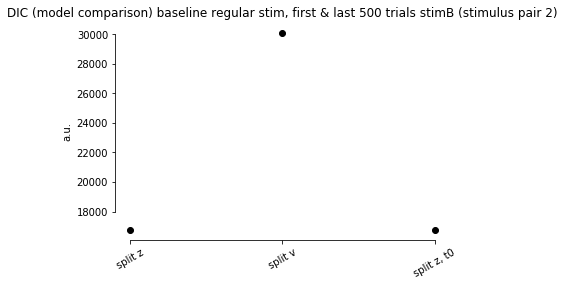

In [77]:
# model comparison

simple_variable_DICs = {'split_z': m_transp_by_phase_stimcoding_splitz.dic, 
                        'split_v': m_transp_by_phase_stimcoding_splitv.dic,
                       'split_z_t0': m_transp_by_phase_stimcoding_splitv_t0.dic} #, 
#                         'split_v_z': m_transp_by_phase_stimcoding_splitv.dic}

models = ['split z', 'split v', 'split z, t0'] #, 'split v & z']
fig,ax = plt.subplots(1)

ax.plot([simple_variable_DICs['split_z'], 
          simple_variable_DICs['split_v'],
        simple_variable_DICs['split_z_t0']], 
          #simple_variable_DICs['split_v_z']], 
         linestyle=' ', marker='o', color = 'black')
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation = 30)
# ax.set_yticks([44000, 51000])
ax.set_ylabel('a.u.')
ax.set_title('DIC (model comparison) baseline regular stim, first & last 500 trials stimB (stimulus pair 2)')

sns.despine(trim=True)
fig.savefig('DIC_hddm_model_comparison_transp_stimcoding.pdf')
fig.show()

Plotting a(-1)
Plotting a(0)
Plotting a(1)
Plotting a_std
Plotting v(-1)
Plotting v(0)
Plotting v(1)
Plotting v_std
Plotting t(-1)
Plotting t(0)
Plotting t(1)
Plotting t_std
Plotting z(-1)
Plotting z(0)
Plotting z(1)
Plotting z_std


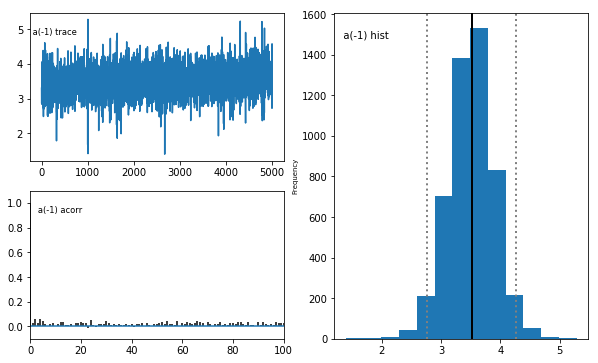

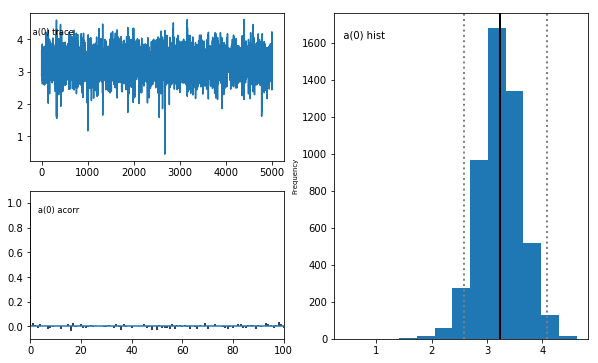

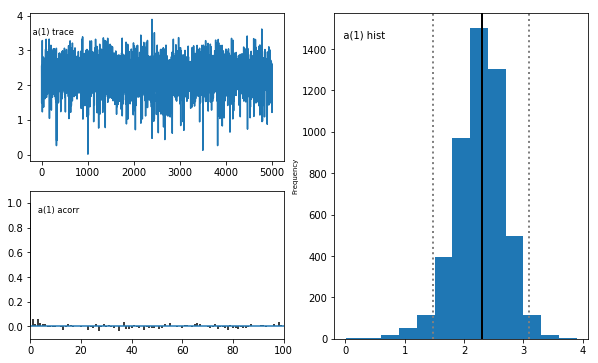

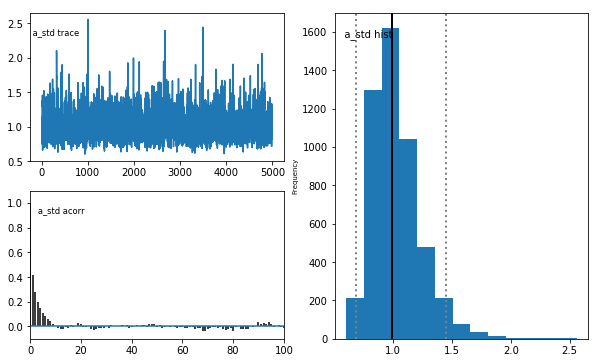

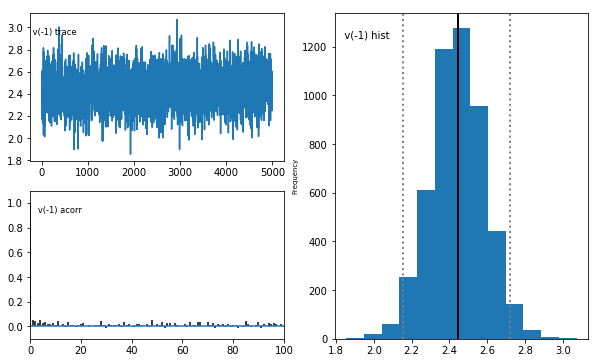

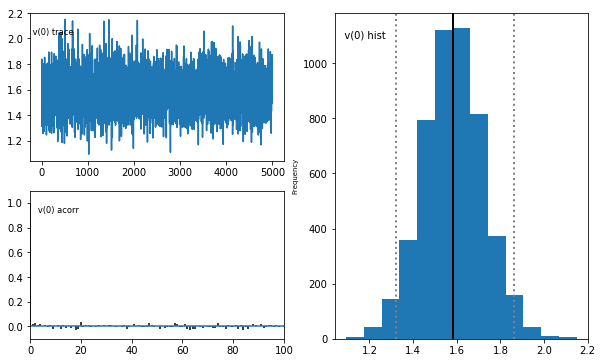

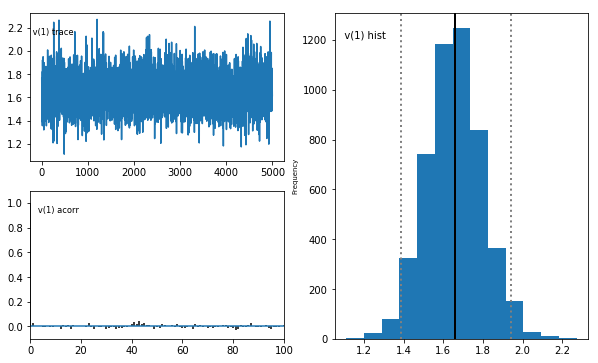

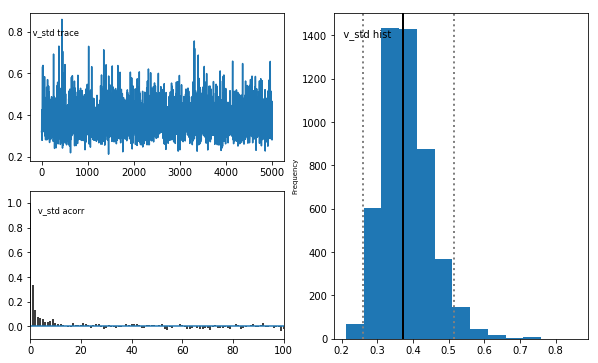

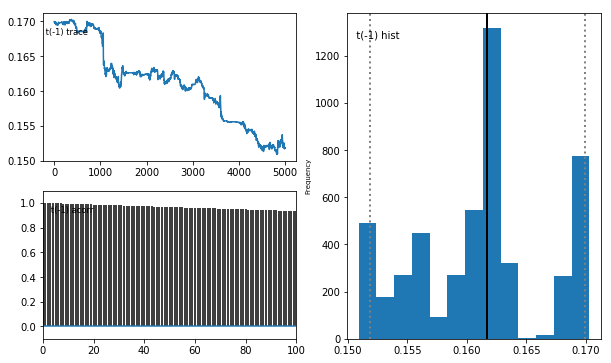

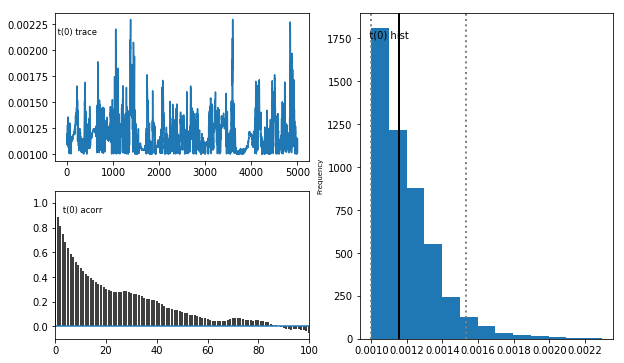

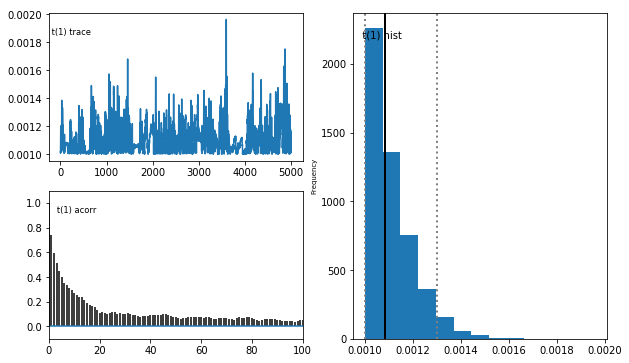

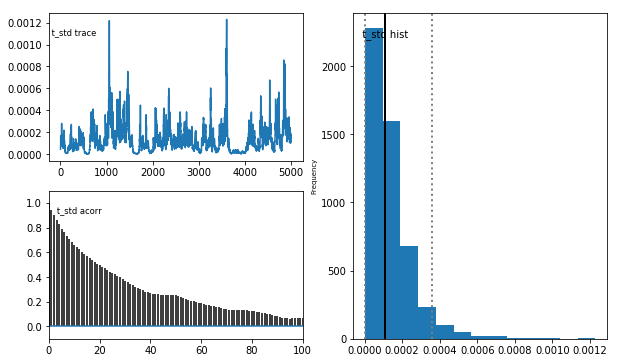

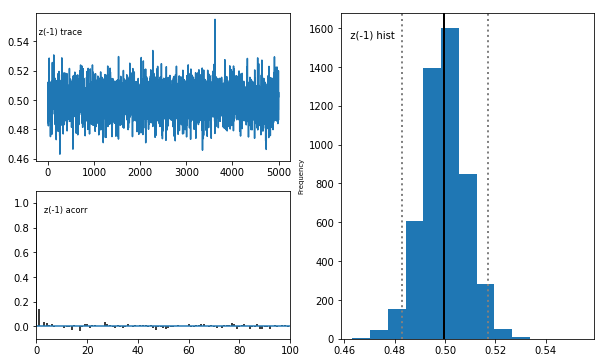

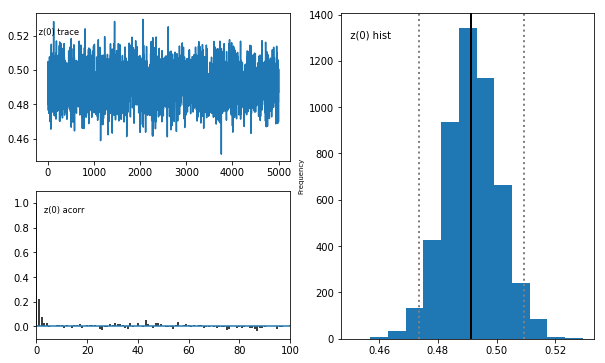

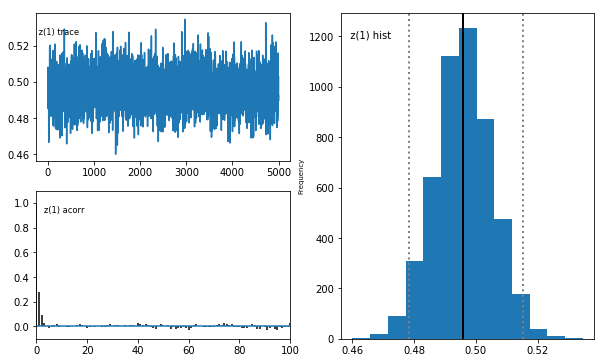

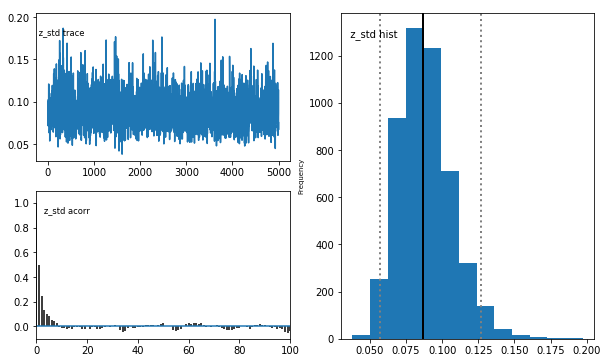

In [102]:
m_transp_by_phase_stimcoding_splitv_t0.plot_posteriors()

In [103]:
transp_by_phase_stimcoding_splitz_t0_stats['mean']['z(-1)']

0.49955396014386944

### Plot parameters

/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/Users/javier/anaconda2/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Passing `normed=

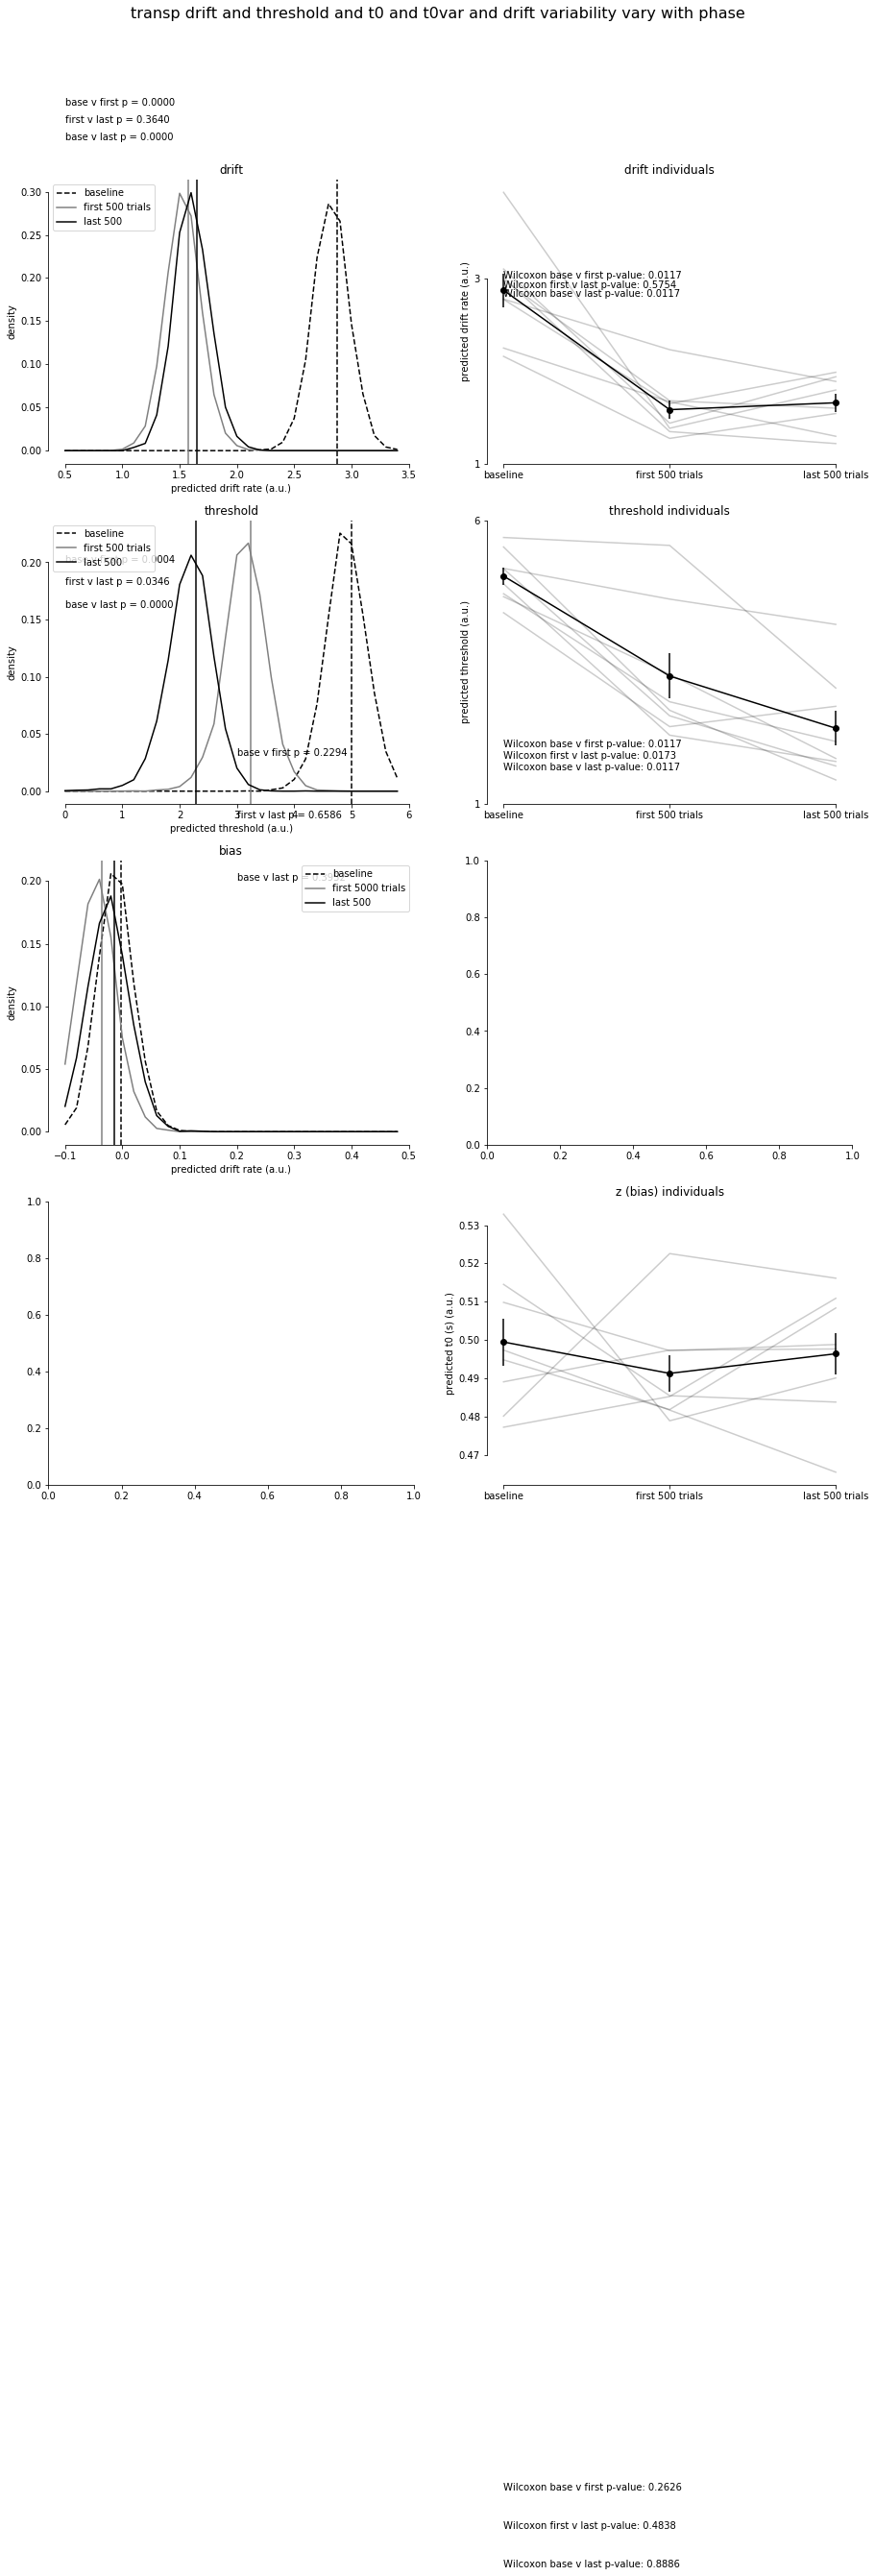

In [41]:
# drift and threshold and drift variability vary with phase

fig, ax = plt.subplots(4,2, figsize = (15,25))

data = transp_by_phase_stimcoding_splitz
data_stats = transp_by_phase_stimcoding_splitz_stats


# drifts average
range_ = (0.5, 3.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['v(-1)']
x0 = data['v(0)']
x1 = data['v(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff < 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[0,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[0,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[0,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[0,0].axvline(np.median(x1), color = 'black')

ax[0,0].set_ylabel('density')
ax[0,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[0,0].text(0.5, 0.4, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[0,0].text(0.5, 0.38, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[0,0].text(0.5, 0.36, s)
ax[0,0].legend()
ax[0,0].set_title('drift')

# drifts individuals
stats = data_stats
cond__1 = 'v_subj(-1)'
cond_0 = 'v_subj(0)'
cond_1 = 'v_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])


x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[0,1].plot(x,y, color = 'black', alpha = 0.2)
ax[0,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[0,1].set_xticks([-1,0,1])
ax[0,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[0,1].set_xlabel('trials')
ax[0,1].set_yticks([1,3])
ax[0,1].set_ylabel('predicted drift rate (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[0,1].text(-1, 3, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[0,1].text(-1, 2.9, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[0,1].text(-1, 2.8, s)
ax[0,1].set_title('drift individuals')


# thresholds average
range_ = (0, 6)
n_bins = 30
alpha = 1
normed = True

x_1 = data['a(-1)']
x0 = data['a(0)']
x1 = data['a(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
ax[1,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
ax[1,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[1,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[1,0].axvline(np.median(x1), color = 'black')

ax[1,0].set_ylabel('density')
ax[1,0].set_xlabel('predicted threshold (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[1,0].text(0, 0.2, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[1,0].text(0, 0.18, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[1,0].text(0, 0.16, s)
ax[1,0].legend()
ax[1,0].set_title('threshold')

# thresholds individuals
stats = data_stats
cond__1 = 'a_subj(-1)'
cond_0 = 'a_subj(0)'
cond_1 = 'a_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[1,1].plot(x,y, color = 'black', alpha = 0.2)
ax[1,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[1,1].set_xticks([-1,0,1])
ax[1,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
ax[1,1].set_yticks([1,6])
ax[1,1].set_ylabel('predicted threshold (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[1,1].text(-1, 2, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[1,1].text(-1, 1.8, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[1,1].text(-1, 1.6, s)
ax[1,1].set_title('threshold individuals')


# starting point (bias) average
range_ = (-0.1, 0.5)
n_bins = 30
alpha = 1
normed = True

x_1 = data['z_trans(-1)']
x0 = data['z_trans(0)']
x1 = data['z_trans(1)']

diff = np.subtract(x_1,x0)
pval_b_v_f = np.sum(diff < 0) / len(diff)
diff = np.subtract(x1, x0)
pval_f_v_l = np.sum(diff > 0) / len(diff)
diff = np.subtract(x_1,x1)
pval_b_v_l = np.sum(diff < 0) / len(diff)

hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', linestyle = '--', label = 'baseline')
ax[2,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 5000 trials')
ax[2,0].axvline(np.median(x0), color = 'gray')

hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
ax[2,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
ax[2,0].axvline(np.median(x1), color = 'black')

ax[2,0].set_ylabel('density')
ax[2,0].set_xlabel('predicted drift rate (a.u.)')
s = 'base v first p = %.4f' %pval_b_v_f
ax[2,0].text(0.2, 0.3, s)
s = 'first v last p = %.4f' %pval_f_v_l
ax[2,0].text(0.2, 0.25, s)
s = 'base v last p = %.4f' %pval_b_v_l
ax[2,0].text(0.2, 0.2, s)
ax[2,0].legend()
ax[2,0].set_title('bias')

# starting point (bias) individuals
stats = data_stats
cond__1 = 'z_subj(-1)'
cond_0 = 'z_subj(0)'
cond_1 = 'z_subj(1)'

idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
means__1 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
means_0 = np.array(stats['mean'].iloc[idx])

idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
means_1 = np.array(stats['mean'].iloc[idx])

x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
y = np.array([means__1, means_0, means_1])

ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
xidx = [-1,0,1]

ax[3,1].plot(x,y, color = 'black', alpha = 0.2)
ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
ax[3,1].set_xticks([-1,0,1])
ax[3,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# ax[1,1].set_yticks([1.25,2.75])
ax[3,1].set_ylabel('predicted t0 (s) (a.u.)')
s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
ax[3,1].text(-1, 0.2, s)
s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
ax[3,1].text(-1, 0.19, s)
s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
ax[3,1].text(-1, 0.18, s)
ax[3,1].set_title('z (bias) individuals')

# # t0 average
# range_ = (0, 1)
# n_bins = 30
# alpha = 1
# normed = True

# x_1 = data['t(-1)']
# x0 = data['t(0)']
# x1 = data['t(1)']

# diff = np.subtract(x_1,x0)
# pval_b_v_f = np.sum(diff < 0) / len(diff)
# diff = np.subtract(x1, x0)
# pval_f_v_l = np.sum(diff > 0) / len(diff)
# diff = np.subtract(x_1,x1)
# pval_b_v_l = np.sum(diff < 0) / len(diff)

# hist1, bins1 = np.histogram(x_1, bins = n_bins, normed = normed, range = range_)
# ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black',linestyle = '--', label = 'baseline')
# ax[3,0].axvline(np.median(x_1), color = 'black', linestyle = '--')

# hist1, bins1 = np.histogram(x0, bins = n_bins, normed = normed, range = range_)
# ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'gray', label = 'first 500 trials')
# ax[3,0].axvline(np.median(x0), color = 'gray')

# hist1, bins1 = np.histogram(x1, bins = n_bins, normed = normed, range = range_)
# ax[3,0].plot(bins1[:-1], hist1*(range_[1]/n_bins), color = 'black', label = 'last 500')
# ax[3,0].axvline(np.median(x1), color = 'black')

# ax[3,0].set_ylabel('density')
# ax[3,0].set_xlabel('predicted t0 (s) (a.u.)')
# s = 'base v first p = %.4f' %pval_b_v_f
# ax[3,0].text(0.3, 0.14, s)
# s = 'first v last p = %.4f' %pval_f_v_l
# ax[3,0].text(0.3, 0.13, s)
# s = 'base v last p = %.4f' %pval_b_v_l
# ax[3,0].text(0.3, 0.12, s)
# ax[3,0].legend()
# ax[3,0].set_title('t0 (s)')

# # t0 individuals
# stats = data_stats
# cond__1 = 't_subj(-1)'
# cond_0 = 't_subj(0)'
# cond_1 = 't_subj(1)'

# idx = [x for x,subj in enumerate(stats.index) if cond__1 in subj] 
# means__1 = np.array(stats['mean'].iloc[idx])

# idx = [x for x,subj in enumerate(stats.index) if cond_0 in subj] 
# means_0 = np.array(stats['mean'].iloc[idx])

# idx = [x for x,subj in enumerate(stats.index) if cond_1 in subj] 
# means_1 = np.array(stats['mean'].iloc[idx])

# x = np.array([np.repeat([-1], len(idx)), np.repeat([0], len(idx)), np.repeat([1], len(idx))])
# y = np.array([means__1, means_0, means_1])

# ymean = [np.mean(means__1), np.mean(means_0), np.mean(means_1)]
# ysem = [np.std(means__1)/math.sqrt(len(idx)), np.std(means_0)/math.sqrt(len(idx)), np.std(means_1)/math.sqrt(len(idx))]
# xidx = [-1,0,1]

# ax[3,1].plot(x,y, color = 'black', alpha = 0.2)
# ax[3,1].errorbar(x = xidx, y = ymean, yerr = ysem, marker = 'o', color = 'black')
# ax[3,1].set_xticks([-1,0,1])
# ax[3,1].set_xticklabels(['baseline','first 500 trials', 'last 500 trials'])
# # ax[1,1].set_yticks([1.25,2.75])
# ax[3,1].set_ylabel('predicted t0 (s) (a.u.)')
# s = 'Wilcoxon base v first p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_0)[1]
# ax[3,1].text(-1, 0.2, s)
# s = 'Wilcoxon first v last p-value: %.4f' %scipy.stats.wilcoxon(means_0, means_1)[1]
# ax[3,1].text(-1, 0.19, s)
# s = 'Wilcoxon base v last p-value: %.4f' %scipy.stats.wilcoxon(means__1, means_1)[1]
# ax[3,1].text(-1, 0.18, s)
# ax[3,1].set_title('t0 individuals')


fig.suptitle('transp drift and threshold and t0 and t0var and drift variability vary with phase', fontsize = 16)
sns.despine(trim=True)
# fig.savefig('transp_baseline_first_and_last500_drift_thresh_t0_and_driftvar_poutlier0005_hddm_fits.pdf')
fig.show()